In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

In [2]:
#чтение данных
df = pd.read_csv('train.csv')

In [3]:
#shape and data types of the data
print(df.shape)
print(df.dtypes)

#отбор числовых колонок
df_num = df.select_dtypes(include=[np.number])
num_cols = df_num.columns.values
print(num_cols)

#отбор нечисловых колонок
df_non_num = df.select_dtypes(exclude=[np.number])
non_num_cols = df_non_num.columns.values
print(non_num_cols)

(30471, 292)
id                      int64
timestamp              object
full_sq                 int64
life_sq               float64
floor                 float64
                       ...   
mosque_count_5000       int64
leisure_count_5000      int64
sport_count_5000        int64
market_count_5000       int64
price_doc               int64
Length: 292, dtype: object
['id' 'full_sq' 'life_sq' 'floor' 'max_floor' 'material' 'build_year'
 'num_room' 'kitch_sq' 'state' 'area_m' 'raion_popul' 'green_zone_part'
 'indust_part' 'children_preschool' 'preschool_quota'
 'preschool_education_centers_raion' 'children_school' 'school_quota'
 'school_education_centers_raion' 'school_education_centers_top_20_raion'
 'hospital_beds_raion' 'healthcare_centers_raion'
 'university_top_20_raion' 'sport_objects_raion'
 'additional_education_raion' 'culture_objects_top_25_raion'
 'shopping_centers_raion' 'office_raion' 'full_all' 'male_f' 'female_f'
 'young_all' 'young_male' 'young_female' 'work_all' 'work_

create missing indicator for: life_sq
create missing indicator for: floor
create missing indicator for: max_floor
create missing indicator for: material
create missing indicator for: build_year
create missing indicator for: num_room
create missing indicator for: kitch_sq
create missing indicator for: state
create missing indicator for: preschool_quota
create missing indicator for: school_quota
create missing indicator for: hospital_beds_raion
create missing indicator for: raion_build_count_with_material_info
create missing indicator for: build_count_block
create missing indicator for: build_count_wood
create missing indicator for: build_count_frame
create missing indicator for: build_count_brick
create missing indicator for: build_count_monolith
create missing indicator for: build_count_panel
create missing indicator for: build_count_foam
create missing indicator for: build_count_slag
create missing indicator for: build_count_mix
create missing indicator for: raion_build_count_with_bui

<Axes: xlabel='num_missing'>

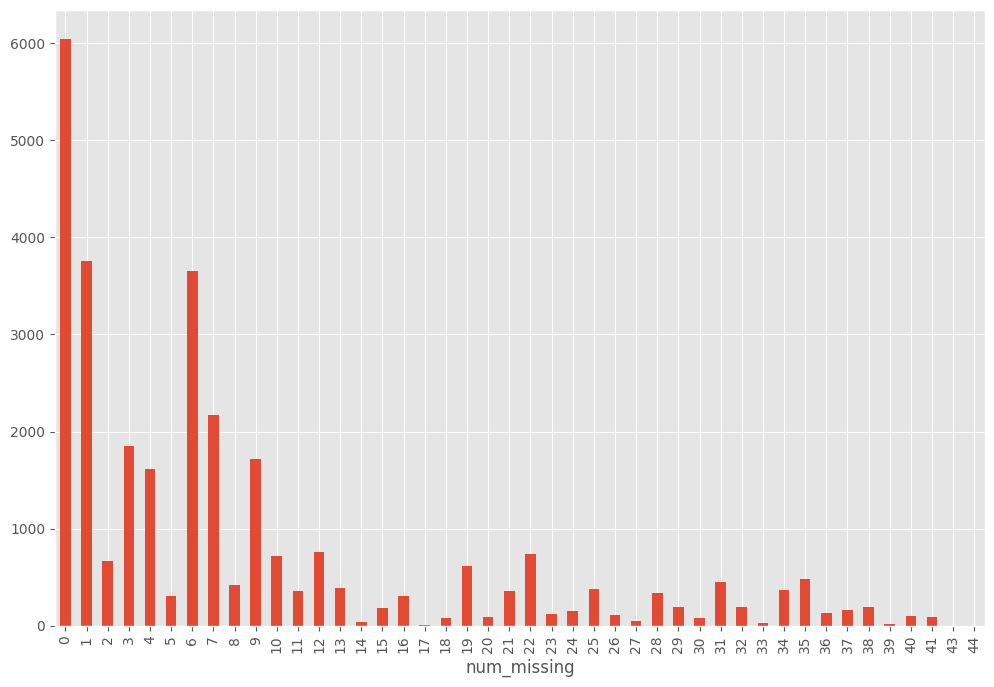

In [4]:
# сначала создадим индикатор для признаков с пропущенными данными
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)

    if num_missing > 0:
        print('create missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing

# далее на основе индикатора строим гистограмму
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().sort_index().plot.bar(x='count', y='num_missing')

In [5]:
ind_missing = df[df['num_missing'] > 35].index
df_less_missing_rows = df.drop(ind_missing, axis=0)

<Axes: xlabel='num_missing'>

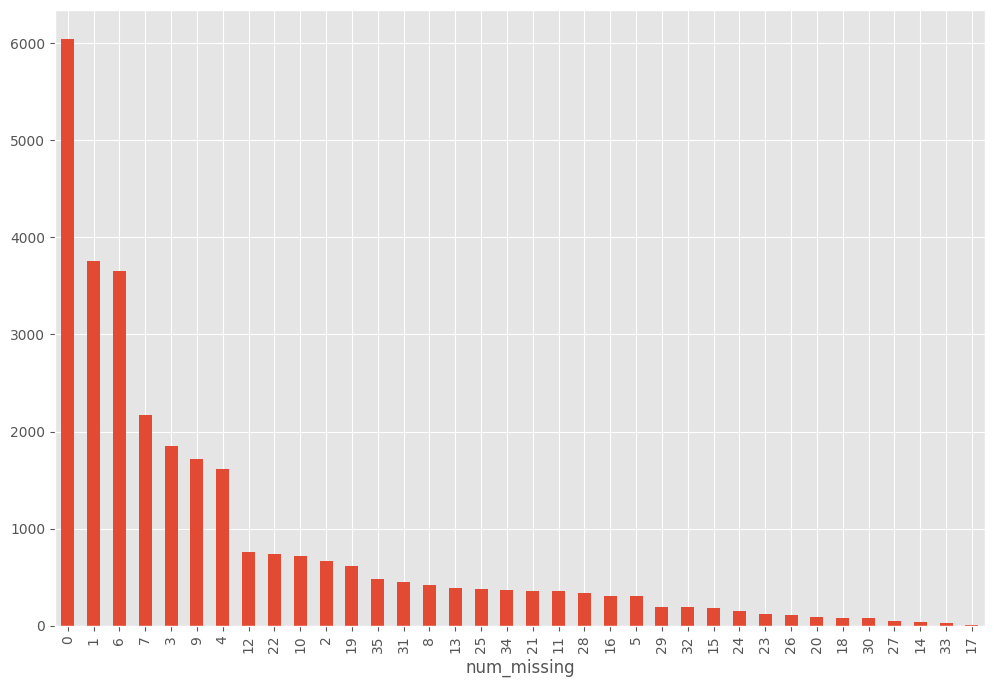

In [6]:
df_less_missing_rows['num_missing'].value_counts().plot.bar(x='count', y='num_missing')

In [7]:
cols_to_drop = ['hospital_beds_raion']
df_less_hos_beds_raion = df.drop(cols_to_drop, axis=1)

In [8]:
med = df['life_sq'].median()
print(med)
df['life_sq'] = df['life_sq'].fillna(med)

30.0


In [9]:
#замена недостающих значений

df['sub_area'] = df['sub_area'].fillna('_MISSING_')

df['life_sq'] = df['life_sq'].fillna(-999)

In [10]:
# 2. Нетепичные данные(выбросы)
# Выбросы - это данные, которые существенно отличаются от других наблюдений. Они могут сооьветствовать
# реальным отклонениям, но могут быть и просто ошибками
# 2.1 Как обнаружить?
# Для численных и категориальных признаков используются разные методы изучения распределения,
# позволяющие обнаружить выбросы
# 2.1.1 Гистограмма/коробчатая диаграмма
# Если признак численный, можно построить гистограмму или коробчатую диаграмму (ящик с усами).
# Посмотрим на примере уже знакомого нам признака life_sq

<Axes: >

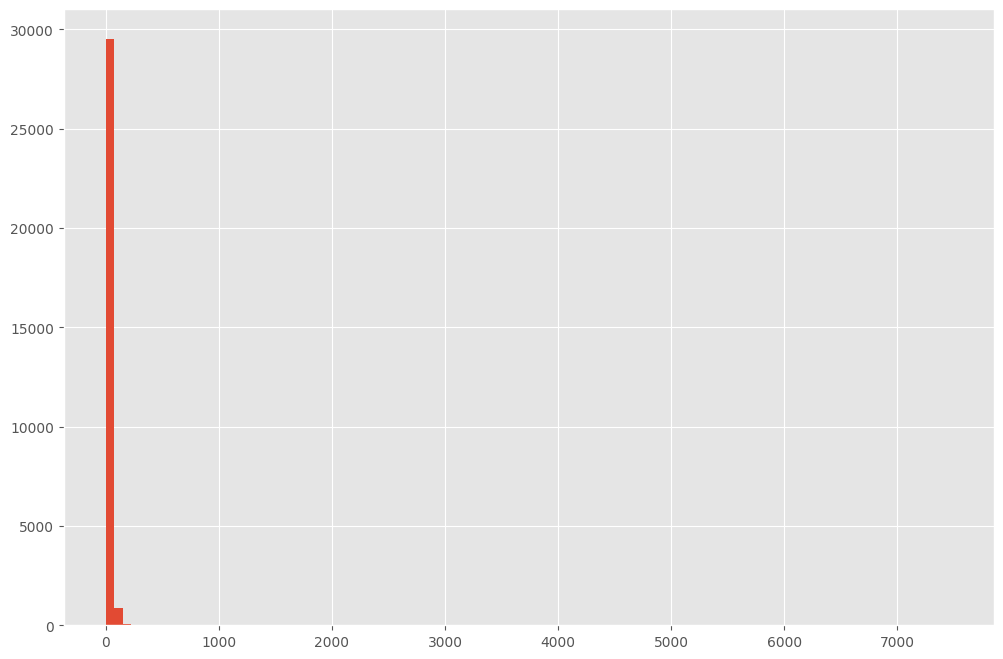

In [11]:
df['life_sq'].hist(bins=100)

<Axes: >

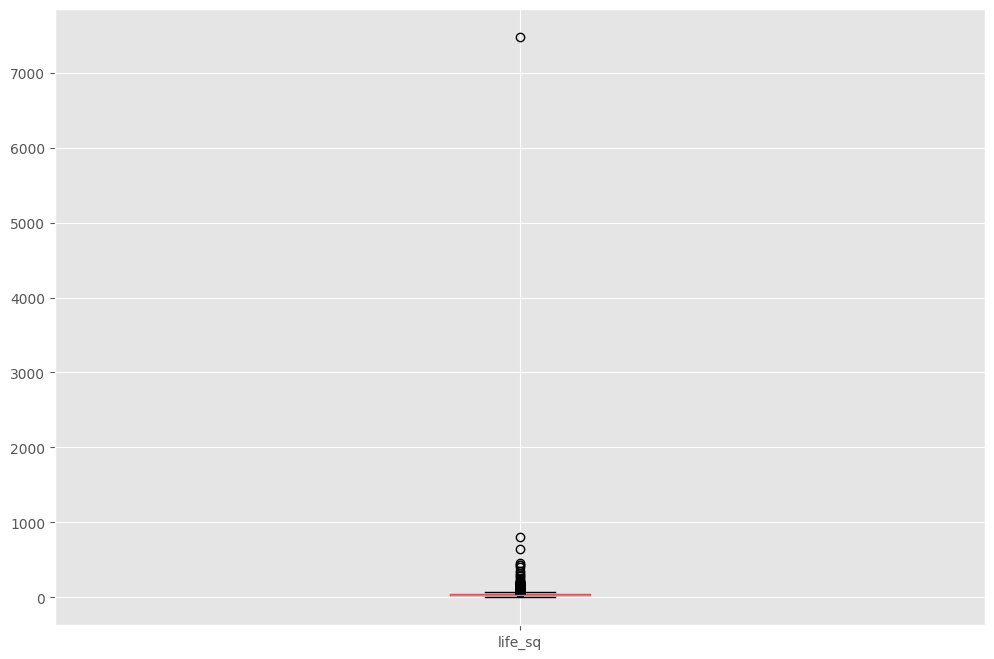

In [12]:
# Из-за возможных выбросов данные выглядят сильно искаженными
# Чтобы изучить особенность поближе, построим коробчатую диаграмму

df.boxplot(column=['life_sq'])

In [13]:
# 2.1.2 Описательная статистика
# Отклонения численных признаков могут быть слишком четкими, чтобы
# не визуализироваться коробчатой диаграммой. Вместо этого можно 
# проанализировать их описательную статистику

df['life_sq'].describe()

count    30471.000000
mean        33.480883
std         46.522251
min          0.000000
25%         22.000000
50%         30.000000
75%         38.000000
max       7478.000000
Name: life_sq, dtype: float64

In [ ]:
# Для признака life_sq видно, что максимальное значение равно 7478, в 
# то время как 75% квартиль равен только 43. Значение 7478 - выброс

In [ ]:
# 2.1.3 Столбчатая диаграмма

<Axes: xlabel='ecology'>

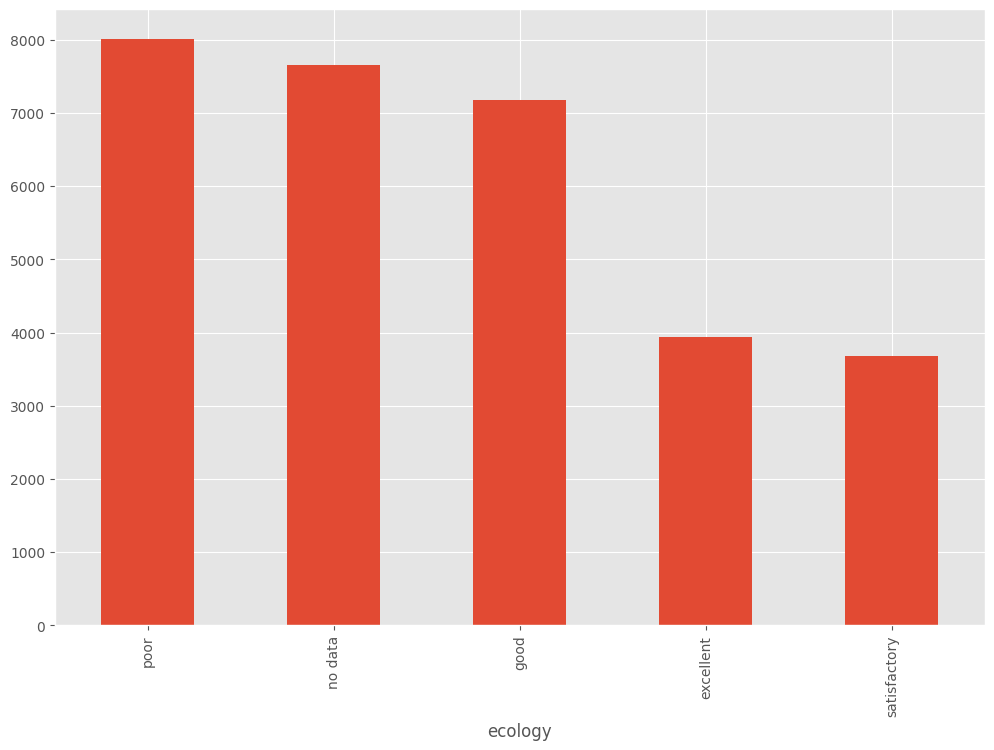

In [14]:
df['ecology'].value_counts().plot.bar()

In [16]:
# 3. Неинформативные признаки 
# Составим список признаков, у которых более 95% строк содержат 
# одно и то же значение

num_rows = len(df.index)
low_information_cols = []

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]

    if top_pct > 0.95:
         print('{0}: {1:.5f}%'.format(col, top_pct*100))
         print(cnts)
         print()

oil_chemistry_raion: 99.02858%
oil_chemistry_raion
no     30175
yes      296
Name: count, dtype: int64

railroad_terminal_raion: 96.27187%
railroad_terminal_raion
no     29335
yes     1136
Name: count, dtype: int64

nuclear_reactor_raion: 97.16780%
nuclear_reactor_raion
no     29608
yes      863
Name: count, dtype: int64

big_road1_1line: 97.43691%
big_road1_1line
no     29690
yes      781
Name: count, dtype: int64

railroad_1line: 97.06934%
railroad_1line
no     29578
yes      893
Name: count, dtype: int64

cafe_count_500_price_high: 97.25641%
cafe_count_500_price_high
0    29635
1      787
2       38
3       11
Name: count, dtype: int64

mosque_count_500: 99.51101%
mosque_count_500
0    30322
1      149
Name: count, dtype: int64

cafe_count_1000_price_high: 95.52689%
cafe_count_1000_price_high
0    29108
1     1104
2      145
3       51
4       39
5       15
6        8
7        1
Name: count, dtype: int64

mosque_count_1000: 98.08342%
mosque_count_1000
0    29887
1      584
Name: cou

In [ ]:
# теперь можно последовательно перебрать их и определить, 
# несут ли они полезную информацию

In [ ]:
# Как обнаружить повторяющиеся записи?

In [42]:
# отбрасываем неуникальные строки
df_dedupped = df.drop('id', axis=1).drop_duplicates()

# сравниваем формы старого и нового наборов
print(df.shape)
print(df_dedupped.shape)

(30471, 344)
(30461, 343)


In [ ]:
# Другой распространенный способ вычисления дубликатов: по набору 
# ключевых признаков. Например, неуникальной можно считать запись
# с одной и той же площадью жилья, ценой и годом постройки.

# Найдем в нашем наборе дубликаты по группе критических признаков - 
# full_sq, life_sq, floor, build_year, num_room, price_doc

In [44]:
key = ['timestamp', 'full_sq', 'life_sq', 'floor', 'build_year',
       'num_room', 'price_doc']
df.fillna(-999).groupby(key)['id'].count().sort_values(
    ascending=False).head(20)

timestamp   full_sq  life_sq  floor  build_year  num_room  price_doc
2013-12-18  39       30.0     6.0    -999.0       1.0      3700946      2
2015-03-30  41       41.0     11.0    2016.0      1.0      4114580      2
2015-03-14  62       30.0     2.0    -999.0       2.0      6520500      2
2013-12-05  40       30.0     5.0    -999.0       1.0      4414080      2
2013-06-24  40       30.0     12.0   -999.0      -999.0    4112800      2
2013-08-30  40       30.0     12.0   -999.0       1.0      4462000      2
2014-12-09  40       30.0     17.0   -999.0       1.0      4607265      2
2012-08-27  59       30.0     6.0    -999.0      -999.0    4506800      2
2014-04-15  134      134.0    1.0     0.0         3.0      5798496      2
2013-09-23  85       30.0     14.0   -999.0       3.0      7725974      2
2014-01-22  46       28.0     1.0     1968.0      2.0      3000000      2
2014-12-17  62       30.0     9.0    -999.0       2.0      6552000      2
2012-10-22  61       30.0     18.0   -999.0

In [45]:
# Что делать с дубликатами?

# Вот так выглядит удаление дубликатов, основанное на наборе 
# ключевых признаков:

key = ['timestamp', 'full_sq', 'life_sq', 'floor', 'build_year',
       'num_room', 'price_doc']
df_dedupped2 = df.drop_duplicates(subset=key)

print(df.shape)
print(df_dedupped2.shape)

(30471, 344)
(30455, 344)


In [46]:
# Разные регистры символов
# Как обнаружить?

df['sub_area'].value_counts(dropna=False)

sub_area
Poselenie Sosenskoe               1776
Nekrasovka                        1611
Poselenie Vnukovskoe              1372
Poselenie Moskovskij               925
Poselenie Voskresenskoe            713
                                  ... 
Molzhaninovskoe                      3
Poselenie Shhapovskoe                2
Poselenie Kievskij                   2
Poselenie Klenovskoe                 1
Poselenie Mihajlovo-Jarcevskoe       1
Name: count, Length: 146, dtype: int64

In [47]:
# Эта проблема легко решается принудительным изменением регистра:
# пусть все будет в нижнем регистре

df['sub_area_lower'] = df['sub_area'].str.lower()
df['sub_area_lower'].value_counts(dropna=False)


sub_area_lower
poselenie sosenskoe               1776
nekrasovka                        1611
poselenie vnukovskoe              1372
poselenie moskovskij               925
poselenie voskresenskoe            713
                                  ... 
molzhaninovskoe                      3
poselenie shhapovskoe                2
poselenie kievskij                   2
poselenie klenovskoe                 1
poselenie mihajlovo-jarcevskoe       1
Name: count, Length: 146, dtype: int64

In [ ]:
# Разные форматы данных
# Ряд данных в наборе находится не в том формате, с которым нам было
# бы удобно работать. Например, даты, записанные в виде 
# строки, следует преобразовать в формат DataTime 

In [48]:
# Как обнаружить?
# Признак timestamp представляет собой строку, хотя является датой

df

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_avg_price_2000_ismissing,cafe_sum_3000_min_price_avg_ismissing,cafe_sum_3000_max_price_avg_ismissing,cafe_avg_price_3000_ismissing,prom_part_5000_ismissing,cafe_sum_5000_min_price_avg_ismissing,cafe_sum_5000_max_price_avg_ismissing,cafe_avg_price_5000_ismissing,num_missing,sub_area_lower
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,9,bibirevo
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,6,nagatinskij zaton
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,6,tekstil'shhiki
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,7,mitino
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,6,basmannoe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,30469,2015-06-30,44,27.0,7.0,9.0,1.0,1975.0,2.0,6.0,...,False,False,False,False,False,False,False,False,1,otradnoe
30467,30470,2015-06-30,86,59.0,3.0,9.0,2.0,1935.0,4.0,10.0,...,False,False,False,False,False,False,False,False,0,tverskoe
30468,30471,2015-06-30,45,30.0,10.0,20.0,1.0,NaN,1.0,1.0,...,False,False,False,False,False,False,False,False,21,poselenie vnukovskoe
30469,30472,2015-06-30,64,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,...,False,False,False,False,False,False,False,False,0,obruchevskoe


In [51]:
# Чтобы было проще анализировать транзакции по годам и месяцам, 
# значение признака timestamp следует преобразовать в удобный формат

df['timestamp_dt'] = pd.to_datetime(df['timestamp'],
                                   format='%Y-%m-%d')
df['year'] = df['timestamp_dt'].dt.year
df['month'] = df['timestamp_dt'].dt.month
df['weekday'] = df['timestamp_dt'].dt.weekday

print(df['year'].value_counts(dropna=False))
print()
print(df['month'].value_counts(dropna=False))

year
2014    13662
2013     7978
2012     4839
2015     3239
2011      753
Name: count, dtype: int64

month
12    3400
4     3191
3     2972
11    2970
10    2736
6     2570
5     2496
9     2346
2     2275
7     1875
8     1831
1     1809
Name: count, dtype: int64


In [ ]:
# Опечатка
# Как обнаружить?
# Для обнаружения опечаток требуется особый подход. В нашем наборе
# данных о недвижимости нет, поэтому для примера создадим новый набор

# Простой способ идентификации подобных элементов - нечеткая логика
# или редактирование расстояния. Суть этого метода заключается 
# в измерении количества букв (расстояния), которые нам нужно
# изменить, чтобы из одного слова получить другое

In [57]:
from nltk.metrics import edit_distance

df_city_ex = pd.DataFrame(data={'city': ['torontoo',
        'toronto', 'tronto', 'vancouver', 'vancover', 'vancouvr',
        'montreal', 'calgary']})
df_city_ex['city_distance_toronto'] = df_city_ex['city'].map(
    lambda x: edit_distance(x, 'toronto'))
df_city_ex['city_distance_vancouver'] = df_city_ex['city'].map(
    lambda x: edit_distance(x, 'vancouver'))
df_city_ex

,city,city_distance_toronto,city_distance_vancouver
0,torontoo,1,8
1,toronto,0,8
2,tronto,1,8
3,vancouver,8,0
4,vancover,7,1
5,vancouvr,7,1
6,montreal,7,8
7,calgary,7,8


In [58]:
# Мы можем установить критерии для преобразования этих опечаток 
# в правильные значения

msk = df_city_ex['city_distance_toronto'] <= 2
df_city_ex.loc[msk, 'city'] = 'toronto'

msk = df_city_ex['city_distance_vancouver'] <= 2
df_city_ex.loc[msk, 'city'] = 'vancouver'

df_city_ex

,city,city_distance_toronto,city_distance_vancouver
0,toronto,1,8
1,toronto,0,8
2,toronto,1,8
3,vancouver,8,0
4,vancouver,7,1
5,vancouver,7,1
6,montreal,7,8
7,calgary,7,8


In [60]:
# Адреса
# Адреса - ужасная головная боль для всех аналитиков данных.
# Ведь мало кто следует стандартному формату, вводя свой адрес
# в базу данных

# В нашем наборе данных по соображениям конфиденциальности 
# отсутствует признак адреса, поэтому создадим новый набор df_add_ex

df_add_ex = pd.DataFrame(['123 MAIN St Apartment 15', 
        '123 Main Street Apt 12   ', '543 FirSt Av',
        '   876 FIRst Ave.'],  columns=['address'])
df_add_ex

,address
0,123 MAIN St Apartment 15
1,123 Main Street Apt 12
2,543 FirSt Av
3,876 FIRst Ave.


In [ ]:
# Минимальное форматирование включает следующие операции:
# - приведение всех символов к нижнему регитру
# - удаление пробелов в начале и конце строки 
# - удаление точек
# - стандартизации формулировок

In [84]:
df_add_ex['address_std'] = df_add_ex['address'].str.lower()
df_add_ex['address_std'] = df_add_ex['address_std'].str.strip()
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('.','')
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('street', 'st')
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('apartment', 'apt')
df_add_ex['address_std'] = df_add_ex['address_std'].str.replace('av.', 'ave')

df_add_ex

,address,address_std
0,123 MAIN St Apartment 15,123 main st apt 15
1,123 Main Street Apt 12,123 main st apt 12
2,543 FirSt Av,543 first av
3,876 FIRst Ave.,876 first ave
